# Context

Several companies suffer from voluntary churn of costumers and spend millions of dollars trying to reach new clients every year.

When a customer leave, they not only lose their future benefit but also the money spent on marketing.

One of this companies hired you to predict if the if likely to churn or not and, if possible, give some insights about what can be done to improve the service and profit.

# Data Exploring

First, let's import the libraries and the data. Notice that the column names are not in Python's default snake case. Let's rename them just to make it easier to work with the data.

I'm going to use the Data Science Project pipeline presented on **Hands–On Machine Learning with Scikit–Learn and TensorFlow (2e)**, quite simple and useful. Check appendix for further info on this.

In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, scale

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV, StratifiedShuffleSplit

from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score

In [2]:
# Reading data

missing_values = [" ", "na", "--"]
db_raw = pd.read_csv("data/telco-customer-churn.csv", na_values=missing_values)

# Changing column names to snake_case

db_raw.rename(columns={"customerID": "customer_id", 
    "SeniorCitizen": "senior_citizen",
    "Partner": "partner",
    "Dependents": "dependents",
    "PhoneService": "phone_service",
    "MultipleLines": "multiple_lines",
    "InternetService": "internet_service",
    "OnlineSecurity": "online_security",
    "OnlineBackup": "online_backup",
    "DeviceProtection": "device_protection",
    "TechSupport": "tech_support",
    "StreamingTV": "streaming_tv",
    "StreamingMovies": "streaming_movies",
    "Contract": "contract",
    "PaperlessBilling": "paperless_billing",
    "PaymentMethod": "payment_method",
    "MonthlyCharges": "monthly_charges",
    "TotalCharges": "total_charges",
"Churn": "churn"}, inplace=True)

# Change the 'No internet service' and 'No phone service' to 'No'

db_raw.replace('No internet service', 'No', inplace=True)
db_raw.replace('No phone service', 'No', inplace=True)

# Visualize data

display(db_raw.head())

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Now, we need to clean our data, a small inspection of the sheet describing all the variables already tell us that only 3 attributes are numerical and not categorical: "tenure", "monthly_charges" and "total_charges".

Due to that, we need to turn our categorical data into numerical, using an encoder (or manually, if you want to follow a certain order of labelling).

Afterwards, we have a dataset with numbers only, as the method "describe" shows us.

A closer look at the description of the target variable "churn", gives us a precious information about the balance of our dataset. As expected, most telecom clients DON'T voluntary churn (approximately 75% on this data). This has HUGE impact, specially on the models accuracy, because if we simply tell the company that no clients will ever churn, we will have 75% accuracy, which, in several applications of Machine Learning model, is a great achievement. This is going to be further discussed on this notebook.

In [3]:
# Copying the data is important when you are exploring the features, so you don't get many errors when runing a cell

X = db_raw.copy()

# Dealing with the categorical data

cat = ['gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing', 'payment_method', 'churn']

for label in cat:
    X[label] = LabelEncoder().fit_transform(X[label])

# To find duplicates, we can't forget that the "customer_id" column is suposed to be unique, so removing it before looking for duplicates is a great idea

key = X.columns[1:]
X = X.drop_duplicates(subset=key)
X = X.dropna()

# Summarizing the dataframe to check how many duplicates we had

X.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,1,...,1,0,0,0,1,0,3,56.95,1889.50,0
2,3668-QPYBK,1,0,0,0,2,1,0,0,1,...,0,0,0,0,0,1,3,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,0,0,1,...,1,1,0,0,1,0,0,42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


Let's visualize the values of "tenure", "mothly_charges" and "total_charges" on histogram charts. It's logical to think that these 3 variables are somehow related, and this will be verified afterwards.

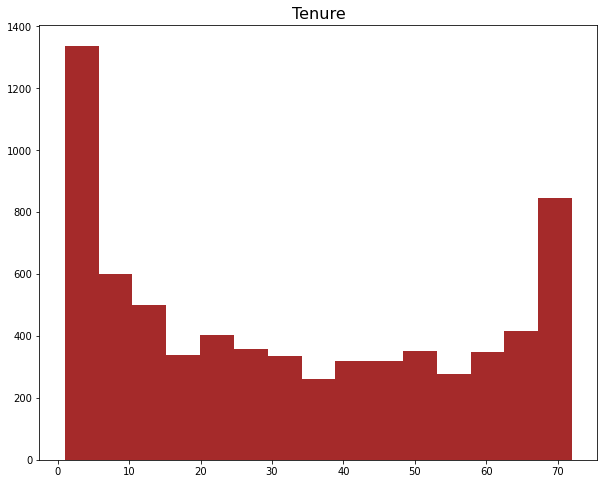

In [4]:
# Plotting a histogram of the "tenure" variable

plt.figure(figsize=(10,8))
plt.hist(X["tenure"], bins='auto', color='brown')
plt.title("Tenure", fontsize=16)
plt.show()

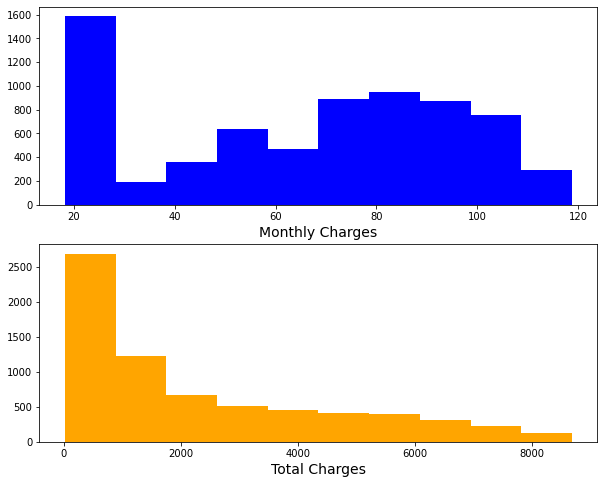

In [5]:
# Plotting histograms of the "monthly_charges" and "total_charges" variables

fig2, axs = plt.subplots(2, 1, figsize=(10,8))
axs[0].hist(X["monthly_charges"], color='blue')
axs[0].set_xlabel('Monthly Charges', fontsize=14)
axs[1].hist(X["total_charges"], color='orange')
axs[1].set_xlabel('Total Charges', fontsize=14)
plt.show()

Although our dataset is considered small for Data Science purposes, we have a lot of variables that, empirically, shouldn't influence on the churn rate we are interesting, like "gender" and a few others.

So, instead of using an Dimensionality Reduction Technique, like PCA, we will reduce the number of variables based on feature importance. We will use two diffent metrics to evaluate the correlation of each variable with our target, the first being a simple linear correlation score, and the second based on decision trees.

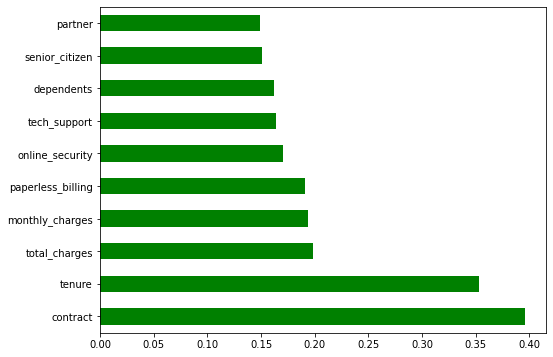

In [6]:
# Find the linear correlation of each feature with our target

linear_corr = abs(X.corr()["churn"]).sort_values(ascending=False)
linear_corr = linear_corr[1:]

# Plotting the largest values

plt.figure(figsize=(8,6))
linear_corr.nlargest(10).plot(kind='barh', color='green')
plt.show()

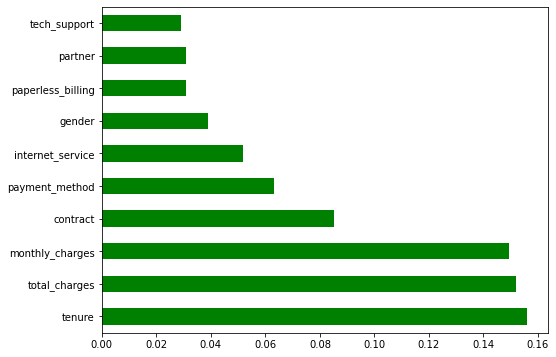

In [7]:
# Find the tree-based correlation of each feature with our target

X_feat = X.drop(["customer_id", "churn"], axis=1)
model = ExtraTreesClassifier()
model.fit(X_feat, X["churn"])
feat_importances = pd.Series(model.feature_importances_, index=X_feat.columns)

# Plotting the largest values

plt.figure(figsize=(8,6))
feat_importances.nlargest(10).plot(kind='barh', color='green')
plt.show()

So, analysing the feature relevances, we can conclude that the best to use on the model are "tenure", "contract", "payment_method", "monthly_charges" and "total_charges". As we've stated before, "tenure" should somehow be related to the charges, so we are going to create a new feature, dividing the "total_charges" by the "monthly_charges" to further explore it.

Besides that, we will create a variable compiling some of the services that the client can hire, to check if we create an even better feature.

In [8]:
# Creating new features based on combinations of others

X["services"] = X["online_security"] + X["tech_support"] + X["online_backup"] + X["device_protection"]

X["charges"] = X["total_charges"]/X["monthly_charges"]

# Dropping the columns that won't be relevant to the model

drops = ["multiple_lines", 
    "phone_service", 
    "gender", 
    "streaming_tv",
    "streaming_movies",
    "internet_service",
    "paperless_billing",
    "partner",
    "senior_citizen",
    "device_protection",
    "online_backup",
    "dependents",
    "tech_support",
    "online_security"]

# Visualizing the data so far

X.drop(drops, axis=1, inplace=True)
X.head()

,customer_id,tenure,contract,payment_method,monthly_charges,total_charges,churn,services,charges
0,7590-VHVEG,1,0,2,29.85,29.85,0,1,1.000000
1,5575-GNVDE,34,1,3,56.95,1889.50,0,2,33.178227
2,3668-QPYBK,2,0,3,53.85,108.15,1,2,2.008357
3,7795-CFOCW,45,1,0,42.30,1840.75,0,3,43.516548
4,9237-HQITU,2,0,2,70.70,151.65,1,0,2.144979


In order to check if the features we've created are relevant or not, we can make a correlation matrix in the form a heatmap (to improve visualization).

Notice that the correlation between "tenure" and the newly added "charges" is 1. This means that if we keep "total_charges" and "monthly_charges" on our dataset, the "ternure" feature will only create confusion and won't improve performance.

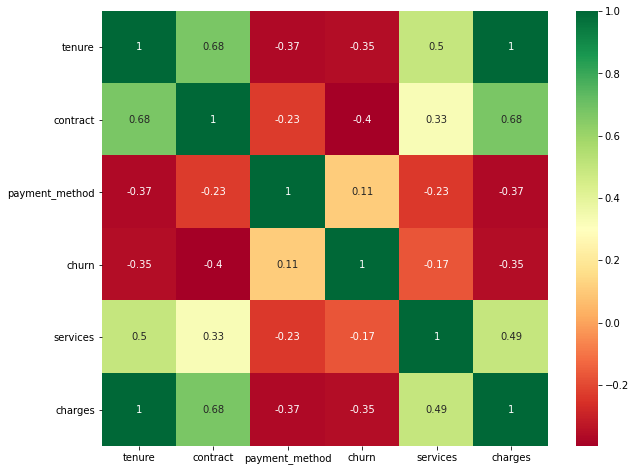

In [9]:
corrmat = X.drop(["customer_id", "monthly_charges", "total_charges"], axis=1).corr()
top_corr_features = corrmat.index

plt.figure(figsize=(10,8))
sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.show()

The final step to prepare our dataset is just scale all features, so we have centered zero mean and unit variance.

In synthesis, the best features are "contract", "payment_method", "mothly_carges", "total_charges" and "services"

In [10]:
# Dropping the final features

final_drops = ["churn", "tenure", "charges"]

# Creating the target array

y = X["churn"]
X.drop(final_drops, axis=1, inplace=True)

# Scaling all features 

for label in X.columns:
    if label != "customer_id":
        X[label] = scale(X[label])

X.head()

,customer_id,contract,payment_method,monthly_charges,total_charges,services
0,7590-VHVEG,-0.828921,0.403418,-1.165523,-0.997284,-0.209392
1,5575-GNVDE,0.371148,1.340759,-0.264071,-0.176848,0.568065
2,3668-QPYBK,-0.828921,1.340759,-0.367189,-0.962740,0.568065
3,7795-CFOCW,0.371148,-1.471264,-0.751387,-0.198355,1.345523
4,9237-HQITU,-0.828921,0.403418,0.193308,-0.943549,-0.986850


# Machine learning model development and evaluation

This is a classification problem, we could use Logistic Regression, SVM, KNN, Decision Trees, Neural Networks, etc. I've chosen four models to do an initial analysis:
- Logistic Regression: simple model that hardly overfits and provide trustworthy precision
- Random Forest: suits well with almost every dataset, even if its huge
- AdaBoost: uses random forest on the backlines with a gradient boost to improce performance
- KNN: it's always great to check if KNN works well on your dataset, it's simple and worst case scenario will give plenty of information if you'd like

In [11]:
# Defining the models we are going to use. The hyperparameters tuning will be discussed later on.

lgr_model = LogisticRegression()

rf_model = rf_model = RandomForestClassifier(n_estimators=1600, 
        min_samples_split=2, min_samples_leaf=4,
        max_features='sqrt', max_depth=10, bootstrap=True)

adaboost_model = AdaBoostClassifier(n_estimators=100, learning_rate=0.3, random_state=0)

knn_model = KNeighborsClassifier(n_neighbors=100, weights='uniform', algorithm='ball_tree')

As we've stated before, our dataset is higly unbalanced, so a great way to compare diferent algorithms without falling into bias and other problems is cross validation and changing the metrics from a simple accuracy score to a more robust ROC AUC (evaluates integral of the curve to get a more meaningful and less biased score).

In [12]:
# Make cross validation of all models above

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
X_clean = X.drop(["customer_id"], axis=1)

lgr_scores = cross_val_score(lgr_model, X_clean, y, scoring='roc_auc', cv=cv, n_jobs=-1)
rf_scores = cross_val_score(rf_model, X_clean, y, scoring='roc_auc', cv=cv, n_jobs=-1)
adaboost_scores = cross_val_score(adaboost_model, X_clean, y, scoring='roc_auc', cv=cv, n_jobs=-1)
knn_scores = cross_val_score(knn_model, X_clean, y, scoring='roc_auc', cv=cv, n_jobs=-1)

print('LGR Accuracy: %.3f (%.3f)' % (np.mean(lgr_scores), np.std(lgr_scores)))
print('RF Accuracy: %.3f (%.3f)' % (np.mean(rf_scores), np.std(rf_scores)))
print('ADA Accuracy: %.3f (%.3f)' % (np.mean(adaboost_scores), np.std(adaboost_scores)))
print('KNN Accuracy: %.3f (%.3f)' % (np.mean(knn_scores), np.std(knn_scores)))

LGR Accuracy: 0.827 (0.007)
RF Accuracy: 0.838 (0.009)
ADA Accuracy: 0.842 (0.007)
KNN Accuracy: 0.832 (0.009)


In terms of accuracy, we have AdaBoost and Random Forest better performing. Because they use the same "decision tree" base, I'll choose KNN and AdaBoost as the main models to be tuned and compared for the task.

Now, we have to think (a lot) to answer a few questions:
- Is this accuracy good?
- Does it make sense for the telecom company to sell them this solution?

To deeper explore what we've accomplished so far, let's plot our predictions on a simple confusion matrix.

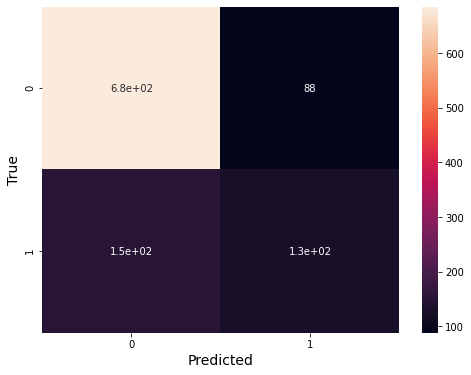

In [13]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.15, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train = X.iloc[train_index] 
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index] 
    y_test = y.iloc[test_index]

model = KNeighborsClassifier(n_neighbors=100, weights='uniform', algorithm='ball_tree')
model.fit(X_train.drop(["customer_id"], axis=1), y_train)
y_pred = model.predict(X_test.drop(["customer_id"], axis=1))

plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred) 
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.show()

Wait, this is a terrible matrix! The telecom company will be very disapointed. 

### We are missing half the positive churns!

This is happening because the unbalanced dataset that I keep talking about and the used metrics. 

The telecom is interested in the accuracy concerning the churns, they already know that approximately 75% of their clients don't cancell the contract!

Interesting enough, machine learning models can be biased on purpose, if we receive the probabilities they predict instead of the final boolean value. This is called changing the model's threshold. Let's try it out.

In [14]:
# Function that calculate the score based on the accuracy of the clients that committed churn

def new_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[1,1]/(cm[1,0] + cm[1,1])

# Function that changes the threshold of the predictions

def new_threshold(y_true, y_pred, t):
    new_pred = []

    for element in y_pred:
        if element[0] < t:
            new_pred.append(1)
        else:
            new_pred.append(0)

    return new_pred

We have no idea of how the tradeoff "overall accuracy" x "new accuracy" will behave as we change the threshold, so we will gather those on arrays and use histograms to analyse the results.

In [15]:
# Defining the lists to store the results and the threshold values

knn_score = []
adaboost_score = []
n = 10

rand = np.random.randint(1, 100, 5)
lins1 = np.linspace(0.5, 0.75, n)
lins2 = np.linspace(0.5, 0.52, n)

new_knn_score = []
knn_score = []

new_adaboost_score = []
adaboost_score = []

for threshold in zip(lins1, lins2):

    new_knn = []
    knn = []

    new_adaboost = []
    adaboost = []

    for state in rand:

        sss = StratifiedShuffleSplit(n_splits=10, test_size=0.15, random_state=state)

        for train_index, test_index in sss.split(X_clean, y):
            X_train = X_clean.iloc[train_index] 
            X_test = X_clean.iloc[test_index]
            y_train = y.iloc[train_index] 
            y_test = y.iloc[test_index]

        knn_model.fit(X_train, y_train)
        knn_pred = knn_model.predict_proba(X_test)
        knn_pred = new_threshold(y_test, knn_pred, threshold[0])
        knn.append(accuracy_score(y_test, knn_pred))
        new_knn.append(new_score(y_test, knn_pred))

        adaboost_model.fit(X_train, y_train)
        adaboost_pred = adaboost_model.predict_proba(X_test)
        adaboost_pred = new_threshold(y_test, adaboost_pred, threshold[1])
        adaboost.append(accuracy_score(y_test, adaboost_pred))
        new_adaboost.append(new_score(y_test, adaboost_pred))

    new_knn_score.append(np.around(100*np.mean(new_knn), 2))
    knn_score.append(np.around(100*np.mean(knn)))

    new_adaboost_score.append(np.around(100*np.mean(new_adaboost)))
    adaboost_score.append(np.around(100*np.mean(adaboost)))

To display the results in a clean way, a bar chart is a great idea.

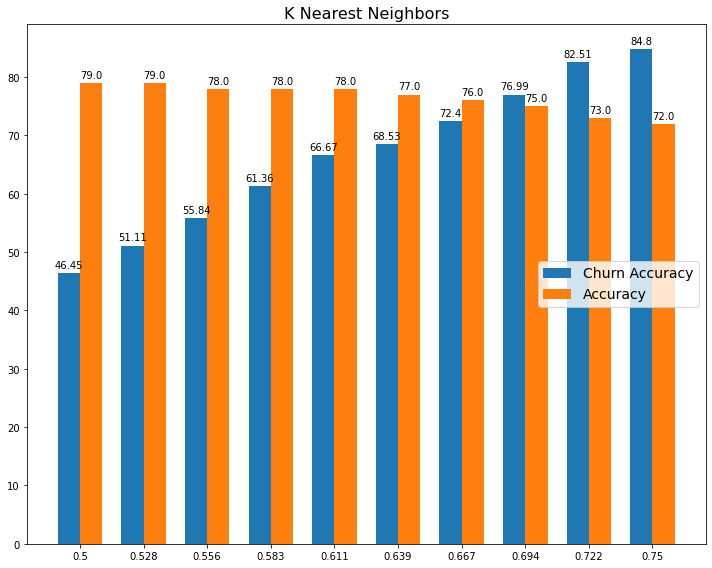

In [16]:
width = 0.35
x = np.arange(n)

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width/2, new_knn_score, width)
rects2 = ax.bar(x + width/2, knn_score, width)

ax.set_title('K Nearest Neighbors', fontsize=16)
ax.set_xticks(np.arange(n))
ax.set_xticklabels(np.around(lins1, 3))
ax.legend(['Churn Accuracy', 'Accuracy'], fontsize=14, loc='center right')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

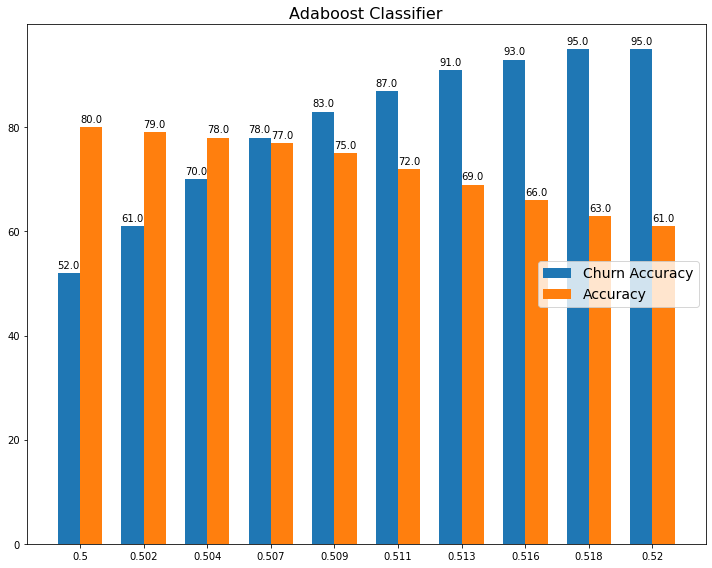

In [17]:
width = 0.35
x = np.arange(n)

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width/2, new_adaboost_score, width)
rects2 = ax.bar(x + width/2, adaboost_score, width)

ax.set_title('Adaboost Classifier', fontsize=16)
ax.set_xticks(np.arange(n))
ax.set_xticklabels(np.around(lins2, 3))
ax.legend(['Churn Accuracy', 'Accuracy'], fontsize=14, loc='center right')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

So, clearly, AdaBoost is way more sensible to the threshold changes, and looks like the ideal model for the task, as we mantain a good accuracy overall while achieving a good score of the clients that are going to churn.

Finally, let's pick the value of 0.51 for the final threshold choice and save our predictions of the test set on a csv file and take a look on our new confusion matrix to check out the results.

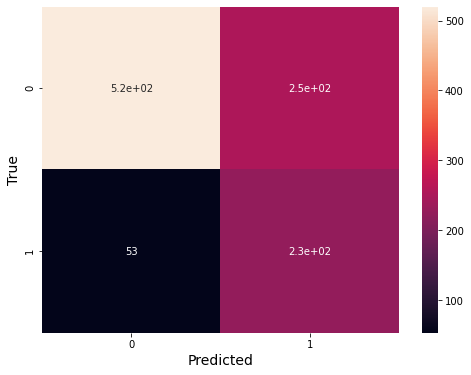

In [18]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.15, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train = X.iloc[train_index] 
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index] 
    y_test = y.iloc[test_index]

model = AdaBoostClassifier(n_estimators=100, learning_rate=0.3, random_state=0)
model.fit(X_train.drop(["customer_id"], axis=1), y_train)

y_pred = model.predict_proba(X_test.drop(["customer_id"], axis=1))
y_pred = new_threshold(y_test, y_pred, 0.51)

plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred) 
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.show()

The confusion matrix is still not pretty but it makes much more sense to the project. Of the 280 positive churns, the algorithm got 230 correctly!

Just out of curiosity, the code I've used to tune the models hyperparameters is displayed below.

# Appendix

## ML Project Pipeline

1. Frame the problem and look at the big picture.
2. Get the data.
3. Explore the data to gain insights.
4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.
5. Explore many different models and short-list the best ones.
6. Fine-tune your models and combine them into a great solution.
7. Present your solution.
8. Launch, monitor, and maintain your system.

Hands-On Machine Learning with Scikit-Learn and TensorFlow
by Aurélien Géron
Copyright © 2017 Aurélien Géron. All rights reserved.

## Tuning Hyperparameters

The confusion matrix is still not pretty but it makes much more sense to the project. Of the 280 positive churns, the algorithm got 230 correctly!

Just out of curiosity, the code I've used to tune the models hyperparameters is displayed below.

In [19]:
def tuning_hyperparameters(X_clean, y):
    
    # Random Forest Hyperparameter Optimization

    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)

    rf_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
                'max_features': ['auto', 'sqrt'],
                'max_depth': max_depth,
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False]}
                
    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=rf_grid, n_iter=100, cv=3, 
        verbose=2, random_state=42, n_jobs=-1)
    rf_random.fit(X_clean, y)

    print(rf_random.best_params_)

    # Ada Boost Hyperparameter Tuning

    ada_grid = {'n_estimators': [50, 100],
        'learning_rate' : [0.01,0.05,0.1,0.3,1]}

    ada = AdaBoostClassifier()
    ada_random = RandomizedSearchCV(estimator=ada, param_distributions=ada_grid, n_iter=100, cv=3, verbose=2, 
        random_state=42, n_jobs=-1)
    ada_random.fit(X_clean, y)

    print(ada_random.best_params_)

    # KNN Hyperparameters Tuning

    knn_grid = {'n_neighbors': [5, 10, 25, 50, 100],
        'weights' : ['uniform', 'distance'],
        'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

    knn = KNeighborsClassifier()
    knn_random = RandomizedSearchCV(estimator=knn, param_distributions=knn_grid, n_iter=100, 
        cv=3, verbose=2, random_state=42, n_jobs=-1)
    knn_random.fit(X_clean, y)

    print(knn_random.best_params_)

    return [rf_random.best_params_, ada_random.best_params_, knn_random.best_params_]

# hyper = tuning_hyperparameters(X_clean, y)